In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option("display.max_colwidth", 200)


Using TensorFlow backend.


In [3]:
data=pd.read_csv("Reviews.csv",nrows=200000)


In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 162834 entries, 0 to 199999
Data columns (total 10 columns):
Id                        162834 non-null int64
ProductId                 162834 non-null object
UserId                    162834 non-null object
ProfileName               162834 non-null object
HelpfulnessNumerator      162834 non-null int64
HelpfulnessDenominator    162834 non-null int64
Score                     162834 non-null int64
Time                      162834 non-null int64
Summary                   162834 non-null object
Text                      162834 non-null object
dtypes: int64(5), object(5)
memory usage: 13.7+ MB


### shortwords dict<preprocessing>

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     /opt/custom/python/anaconda3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
##clean text and summary
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

/opt/custom/python/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/custom/python/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/custom/python/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "http://www.amazon.com/gp/product/b000v9lq30/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  '

In [13]:
print("#samples in train data ",len(cleaned_text),len(cleaned_summary))

#samples in train data  162834 162834


In [14]:
for i in range(5):
    print("Review:",cleaned_text[i])
    print("Summary:",cleaned_summary[i])
    print("---------------------------------")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food
---------------------------------
Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised
---------------------------------
Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: delight says it all
---------------------------------
Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: cough medicine
---------------------------------
Review: great t

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

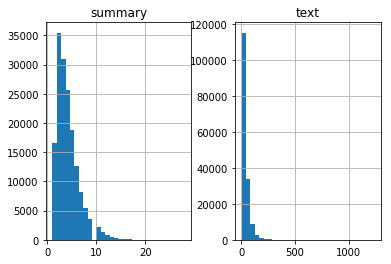

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [18]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=9):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9658065547168884


In [19]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5542989206598973


In [20]:
max_text_len=30
max_summary_len=8
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [21]:
len(df["summary"])

87606

In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [23]:
df['summary'][1]

'sostok not as advertised eostok'

In [24]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [25]:
print(len(x_tr))
print(len(x_val))
print(len(y_tr))
print(len(y_val))

78845
8761
78845
8761


In [26]:
x_tr

array(['delightful product buying pretty easy absolutely addicting everyone wants carmel corn product made packages last weeks yummy',
       'loves tastes good meaty cousin eat meat miss cousin put chopped cilantro onions sour cream top good time',
       'found store carry thankful amazon com carrys son says favorite meal',
       ...,
       'like large variety herbal teas one flavor omega strongly overwhelms tastes pomegranate blubbery probably tea good distinct fishy taste',
       'tasty fast cook convenient drawback little rich calories',
       'obsessed coffee know spring pumpkin spice coffee season feel fortunate able get morning staple season thank transaction flawless satisfied delivery time'],
      dtype=object)

In [27]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [28]:
x_tokenizer.word_counts.items()

odict_items([('delightful', 153), ('product', 14504), ('buying', 2465), ('pretty', 1714), ('easy', 3095), ('absolutely', 1470), ('addicting', 140), ('everyone', 1009), ('wants', 221), ('carmel', 37), ('corn', 672), ('made', 3175), ('packages', 573), ('last', 1637), ('weeks', 526), ('yummy', 1223), ('loves', 4491), ('tastes', 4160), ('good', 19486), ('meaty', 43), ('cousin', 34), ('eat', 4583), ('meat', 583), ('miss', 220), ('put', 1787), ('chopped', 74), ('cilantro', 18), ('onions', 88), ('sour', 520), ('cream', 962), ('top', 858), ('time', 6221), ('found', 3849), ('store', 3643), ('carry', 581), ('thankful', 45), ('amazon', 7192), ('com', 561), ('carrys', 2), ('son', 1210), ('says', 750), ('favorite', 4065), ('meal', 842), ('previously', 121), ('using', 1879), ('kleritea', 3), ('recommended', 1092), ('pharmacist', 5), ('worked', 424), ('expensive', 1681), ('taste', 13969), ('decided', 603), ('try', 4241), ('tea', 9727), ('yogi', 60), ('since', 2455), ('reasonably', 209), ('priced', 46

In [29]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.66472828773297
Total Coverage of rare words: 2.1762127218939047


In [30]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [31]:
x_voc

11466

In [32]:
x_tr

array([[1323,    5,   88, ...,    0,    0,    0],
       [  32,   38,    2, ...,    0,    0,    0],
       [  43,   48,  453, ...,    0,    0,    0],
       ...,
       [   3,  279,  272, ...,    0,    0,    0],
       [  71,  155,  398, ...,    0,    0,    0],
       [3946,    7,  103, ...,    0,    0,    0]], dtype=int32)

In [33]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [34]:
y_tr

array(['sostok scrumptious eostok', 'sostok love this stuff eostok',
       'sostok taste great eostok', ..., 'sostok has fishy taste eostok',
       'sostok tasty yet quick eostok', 'sostok feel fortunate eostok'],
      dtype=object)

In [35]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.86002029822781
Total Coverage of rare words: 3.941994057125159


In [36]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [37]:
y_tokenizer.word_counts

OrderedDict([('sostok', 78845),
             ('scrumptious', 33),
             ('eostok', 78845),
             ('love', 3894),
             ('this', 2673),
             ('stuff', 1248),
             ('taste', 2169),
             ('great', 11024),
             ('works', 340),
             ('and', 3409),
             ('tastes', 695),
             ('good', 7165),
             ('delicious', 2678),
             ('mac', 46),
             ('cheese', 201),
             ('meal', 86),
             ('new', 219),
             ('staple', 45),
             ('for', 3993),
             ('my', 3081),
             ('pantry', 14),
             ('milk', 187),
             ('is', 2272),
             ('really', 666),
             ('seabear', 2),
             ('smoked', 38),
             ('salmon', 73),
             ('trio', 4),
             ('croatian', 1),
             ('chocolates', 56),
             ('well', 196),
             ('worth', 214),
             ('the', 5405),
             ('money', 228),
     

In [38]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(78845, 78845)

In [39]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [40]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [41]:
len(x_tr)

77247

In [47]:
import tensorflow as tf
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
with tf.device("/device:GPU:0"):
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1146600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [39]:
##just importing tf for quick referencing

import tensorflow as tf

In [49]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [50]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [51]:
get_available_gpus()

['/device:GPU:0']

In [52]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=my_callbacks,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

/opt/custom/python/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 77247 samples, validate on 8571 samples
Epoch 1/50
77247/77247 [==============================] - 128s 2ms/step - loss: 2.8330 - val_loss: 2.5868
Epoch 2/50
77247/77247 [==============================] - 113s 1ms/step - loss: 2.5177 - val_loss: 2.4177
Epoch 3/50
77247/77247 [==============================] - 112s 1ms/step - loss: 2.3920 - val_loss: 2.3313
Epoch 4/50
77247/77247 [==============================] - 113s 1ms/step - loss: 2.3101 - val_loss: 2.2662
Epoch 5/50
77247/77247 [==============================] - 112s 1ms/step - loss: 2.2553 - val_loss: 2.2304
Epoch 6/50
77247/77247 [==============================] - 112s 1ms/step - loss: 2.2125 - val_loss: 2.1981
Epoch 7/50
77247/77247 [==============================] - 112s 1ms/step - loss: 2.1770 - val_loss: 2.1767
Epoch 8/50
77247/77247 [==============================] - 112s 1ms/step - loss: 2.1476 - val_loss: 2.1565
Epoch 9/50
77247/77247 [==============================] - 112s 1ms/step - loss: 2.1217 - val_loss: 2.13

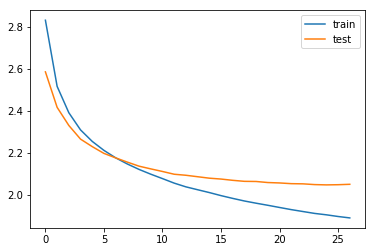

In [53]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [54]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [55]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [56]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [57]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [58]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: delightful product buying pretty easy absolutely addicting everyone wants carmel corn product made packages last weeks yummy 
Original summary: scrumptious 
Predicted summary:  delicious


Review: loves tastes good meaty cousin eat meat miss cousin put chopped cilantro onions sour cream top good time 
Original summary: love this stuff 
Predicted summary:  great taste


Review: found store carry thankful amazon com son says favorite meal 
Original summary: taste great 
Predicted summary:  love this stuff


Review: previously using recommended pharmacist worked expensive taste good decided try tea yogi since reasonably priced works well tastes much better recommend trick 
Original summary: works and tastes good 
Predicted summary:  good product


Review: daughter celiac really missed kraft macaroni cheese luckily found annie loves lives ireland ship case 
Original summary: delicious mac cheese meal 
Predicted summary:  great gluten free pasta


Review: love hot diced tomatoes har

In [68]:
x_val[8]

array([  12,   58, 6606, 4003,   11, 1162,    2,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [111]:
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    #print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: smooth creamy perfect coffee cereals recipes aftertaste like rice drinks plus enriched know still getting calcium 
Predicted summary:  delicious


Review: illy espresso pods hard find go amazon dark roast pods awesome easy use clean best part taste great recommend product 
Predicted summary:  great coffee


Review: ones get restaurants slightly odd taste minty chocolate sure get ones find restaurants 
Predicted summary:  great taste


Review: item arrived time advertised condition would order product amazon 
Predicted summary:  great product


Review: finally got try tin today wow treat king oscar ones tried sardines spring water real good something sardines olive oil like made two compliment sooo well 
Predicted summary:  delicious


Review: cats seem like variety like buy carry indoor cats feed 
Predicted summary:  my cats love this


Review: anyone loves chocolate would like cookies chewy gooey delicious thanks amazon letting us try like much 
Predicted summary:  delicious



In [103]:
def text2sample(custom_review):
    processed_CR=text_cleaner(custom_review,0)
    x_cus_seq    =   x_tokenizer.texts_to_sequences([processed_CR])
    x_cus_pad    =   pad_sequences(x_cus_seq,  maxlen=max_text_len, padding='post')
    np_x_cus=np.array(x_cus_pad[0])
    print("i/p vector : ",np_x_cus)
    return np_x_cus
def predict_sample(custom_review,sample):
    print("original review:",custom_review)
    print("------------------------------------------")
    print("Predicted Summary:",decode_sequence(sample.reshape(1,max_text_len)))
    print("------------------------------------------")

In [105]:
custom_review1="Didn't know what to expect as I entered this small cozy place busseled away in the heart of indiranagar...but what this place lacked in space it made up with its big bold flavours."
review_Vec= text2sample(custom_review1)

i/p vector :  [ 103  642 8339  116 7288  408  227 1382  408 4040 1624   54  170  284
 3027    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [106]:
predict_sample(custom_review1,review_Vec)

original review: Didn't know what to expect as I entered this small cozy place busseled away in the heart of indiranagar...but what this place lacked in space it made up with its big bold flavours.
------------------------------------------
Predicted Summary:  good but not great
------------------------------------------


In [107]:
custom_review2="From the dumplings to the ramen ...food was amazing, every bite was tasty and authentic. I highly recommend this place for a nice little date with some authentic asian flavours.. you won't be disappointed and will leave here with a smile on your face."
review_Vec= text2sample(custom_review2)
predict_sample(custom_review2,review_Vec)

i/p vector :  [6016 1322   25  233   70  535   71 1313   99   40  408   47   22  481
 1313 1301 3027  181  622 3249 1673    0    0    0    0    0    0    0
    0    0]
original review: From the dumplings to the ramen ...food was amazing, every bite was tasty and authentic. I highly recommend this place for a nice little date with some authentic asian flavours.. you won't be disappointed and will leave here with a smile on your face.
------------------------------------------
Predicted Summary:  delicious
------------------------------------------


In [108]:
custom_review3="Dogs/pets were not allowed inside,it was very upsetting. he couldnt taste it.Its a very small place"
review_Vec= text2sample(custom_review3)
predict_sample(custom_review3,review_Vec)

i/p vector :  [  69 1837 2783  607 8199 3023    6  116  408    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
original review: Dogs/pets were not allowed inside,it was very upsetting. he couldnt taste it.Its a very small place
------------------------------------------
Predicted Summary:  not for dogs
------------------------------------------


In [ ]:
##need for attention layer 

##longer the input sequence,it gets harder for encoder to grab the context in to fixed length vector(30 words here).
##Since decoder looks at the entire encoded sequence once,it wont know what to pay attention for and results in bad summarizations

In [109]:
custom_review="Didn't know what to expect as I entered this small cozy place busseled away in the heart of indiranagar...but what this place lacked in space it made up with its big bold flavours.From the dumplings to the ramen ...food was amazing, every bite was tasty and authentic. I highly recommend this place for a nice little date with some authentic asian flavours.. you won't be disappointed and will leave here with a smile on your face.Dogs/pets were not allowed inside,it was very upsetting. he couldnt taste it.Its a very small place"
review_Vec= text2sample(custom_review)
predict_sample(custom_review,review_Vec)

i/p vector :  [6016 1322   25  233   70  535   71 1313   99   40  408   47   22  481
 1313 1301 3027  181  622 3249 1673   69 1837 2783  607 8199 3023    6
  116  408]
original review: Didn't know what to expect as I entered this small cozy place busseled away in the heart of indiranagar...but what this place lacked in space it made up with its big bold flavours.From the dumplings to the ramen ...food was amazing, every bite was tasty and authentic. I highly recommend this place for a nice little date with some authentic asian flavours.. you won't be disappointed and will leave here with a smile on your face.Dogs/pets were not allowed inside,it was very upsetting. he couldnt taste it.Its a very small place
------------------------------------------
Predicted Summary:  my dogs love it
------------------------------------------


##loading weights for inference on cpu

In [114]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'CPU']
get_available_gpus()

['/device:CPU:0']

In [125]:
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        with tf.device("/device:GPU:0"):
            model_infer = load_model("model.26-2.05.h5")


In [126]:
model_infer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1146600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS